# Sympy preamble

In [3]:
from IPython.display import Latex, display
from sympy import Rational, exp, factor, integrate, lambdify, log, oo, pi, sqrt, symbols
from sympy.printing.latex import latex
from sympy.stats import E, Normal as NormalSympy
from fastcore.test import test_close
import pandas as pd
from pyprojroot import here

In [4]:
# symbols used
x, nu, mu, tau, sigma, eps = symbols("x nu mu tau sigma epsilon")


def show(lhs, expr):
    display(Latex("$" + lhs + " = " + latex(expr) + "$"))


def gaussian_log_prob(x, mu, sigma):
    return (
        -1 / 2 * (x - mu) ** 2 / sigma**2 - 1 / 2 * log(2 * pi) - 1 / 2 * log(sigma**2)
    )


# exponential integral of a second order polynomial
# int exp(ax^2 + bx + c) dx
# a has to be negative
def exp_int(poly, x):
    a, b, c = poly.as_poly(x).all_coeffs()
    return sqrt(pi / -a) * exp(b**2 / 4 / -a + c)


# second moment of importance sampling weights w.r.t. G
# for P Gaussian, G Gaussian
def rho_normal():
    p = gaussian_log_prob(x, nu, tau)
    g = gaussian_log_prob(x, mu, sigma)

    return exp_int(2 * p - g, x)


jnp_rho_normal = lambdify((nu, tau, mu, sigma), rho_normal(), "jax")


# second moment of importance sampling weights w.r.t. G
# for P mixture of two Gaussians, G Gaussian
def rho_glmm():
    p1 = gaussian_log_prob(x, nu, tau)
    p2 = gaussian_log_prob(x, -nu, tau)
    g = gaussian_log_prob(x, mu, sigma)

    return (
        1 / 4 * exp_int(2 * p1 - g, x)
        + 1 / 4 * exp_int(2 * p2 - g, x)
        + 1 / 2 * exp_int(p1 + p2 - g, x)
    )


def rho_gsmm():
    p1 = gaussian_log_prob(x, 0.0, 1.0)
    p2 = gaussian_log_prob(x, 0.0, 1 / eps)
    g = gaussian_log_prob(x, mu, sigma)

    return (
        1 / 4 * exp_int(2 * p1 - g, x)
        + 1 / 4 * exp_int(2 * p2 - g, x)
        + 1 / 2 * exp_int(p1 + p2 - g, x)
    )


jnp_rho_glmm = lambdify((nu, tau, mu, sigma), rho_glmm(), "jax")
jnp_rho_gsmm = lambdify((eps, mu, sigma), rho_gsmm(), "jax")

test_close(jnp_rho_glmm(0, 1, 0, 1), 1.0)
test_close(jnp_rho_gsmm(1, 0, 1), 1.0)

In [5]:
rho_gsmm().subs({mu: 0.0, sigma: 1.0}).together()

0.176776695296637*sqrt(1/(1.0*epsilon**2 - 0.5))/(epsilon**(-2))**1.0 + 0.75

# CE / EIS helpers

In [6]:
from jax.scipy.optimize import minimize
import jax.numpy as jnp
import jax.scipy as jsp
from tensorflow_probability.substrates.jax.distributions import (
    MixtureSameFamily,
    Normal,
    Categorical,
)
import jax.random as jrn
import matplotlib.pyplot as plt
from jax import vmap
from functools import partial

key = jrn.PRNGKey(453523498)


def ce_mu(samples, weights):
    mu = jnp.sum(samples * weights) / jnp.sum(weights)
    return mu


def eis_mu(samples, weights, logp, s2):
    (N,) = weights.shape
    X = jnp.array([jnp.ones(N), samples / jnp.sqrt(s2)]).reshape((2, N)).T

    wX = jnp.einsum("i,ij->ij", jnp.sqrt(weights), X)
    logh = Normal(0, jnp.sqrt(s2)).log_prob(samples)
    y = jnp.sqrt(weights) * (logp - logh)
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    mu = beta[1] * jnp.sqrt(s2)
    return mu


def mu_ce_eis(N, key, s2, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array(
        [ce_mu(samples, weights), eis_mu(samples, weights, P.log_prob(samples), s2)]
    )


def ce_s2(samples, weights, mu):
    s2 = jnp.sum((samples - mu) ** 2 * weights) / jnp.sum(weights)
    psi = -1 / 2 / s2
    return psi


def eis_s2(samples, weights, logp, mu):
    (N,) = weights.shape
    X = jnp.array([jnp.ones(N), (samples - mu) ** 2]).T

    wX = jnp.einsum("i,ij->ij", jnp.sqrt(weights), X)
    y = jnp.sqrt(weights) * logp
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    # s2 = -1 / 2 / beta[2]
    return beta[2]


def s2_ce_eis(N, key, mu, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array(
        [ce_s2(samples, weights, mu), eis_s2(samples, weights, P.log_prob(samples), mu)]
    )

# Plotting

In [7]:
import tikzplotlib
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (14, 6)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  # for \text command

# Example 3.3 (univariate Gaussian, $\mu$ fixed)

$\providecommand{\P}{\mathbf P}$
For the asymptotic variance of EIS:
$$
\mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} \underbrace{\left( -\frac{1}{2\tau^{2}} - \psi\right)}_{=a} - \tau^{2} \left(-\frac{1}{2\tau^{2}} - \psi \right) \right)^2 \right) = a^{2} \mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} - \tau^{2} \right)^{2} \right) 
$$
for $\mathbf P = \mathcal N (0,\tau^{2})$

## CE

In [8]:
X = NormalSympy("x", 0, tau)  # X ~ P
T = (X - mu) ** 2
ET = E(T)
Cov_T = (E(T**2) - ET**2).simplify()

# display(Latex("$\\mathbf P T$"))
show("\\mathbf P T", ET)
show("\\text{Cov} (T)", Cov_T)
# CE
psie_ce_normal_variance = -1 / (2 * (tau**2 + mu**2))
show("\\psi_{\\text{CE}}", psie_ce_normal_variance)
I_ce = 1 / (2 * psie_ce_normal_variance**2)
show("I(\\psi)", I_ce)
B_ce = 1 / I_ce
show("\\mathbf B_{\\text{CE}}", B_ce)
M_ce = Cov_T
show("\\mathbf M_{\\text{CE}}", M_ce)
V_ce = B_ce * M_ce * B_ce
show("V_{\\text{CE}}", V_ce)

psi_ce_normal_variance_fun = lambdify((mu, tau), psie_ce_normal_variance, "jax")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## EIS

In [9]:
logp = -Rational(1 / 2) * X**2 / tau**2
CovT_logp = E((T - ET) * (logp - E(logp)))
show("\\text{Cov}(T, \\log p)", CovT_logp)
psi_eis_normal_variance = 1 / Cov_T * CovT_logp
show("\\psi_{\\text{EIS}}", psi_eis_normal_variance)
a = -1 / 2 / tau**2 - psi_eis_normal_variance
# integral = E((X-mu)** 4 * (X**2 - tau**2)**2)
logw = -Rational(1 / 2) * X**2 / tau**2 - psi_eis_normal_variance * T
M_eis = E((X - mu) ** 4 * (logw - E(logw)) ** 2)  # a ** 2 * integral
nu = 3 * tau**4
B_eis = 1 / Cov_T
show("B_{\\text{EIS}}", factor(B_eis.simplify()))
show("M_{\\text{EIS}}", factor(M_eis.simplify()))

V_eis = B_eis * M_eis * B_eis
show("V_{\\text{EIS}}", factor(V_eis.simplify()))
psi_eis_normal_variance_fun = lambdify((mu, tau), psi_eis_normal_variance, "jax")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Data

## parameters

In [10]:
tau2 = 1.0
s2s = jnp.linspace(0.5 * tau2, 3.0 * tau2, 51)
omega2s = jnp.array([0.1, 0.5, 1.0])
eps2s = 1 / jnp.array([0.01, 0.1, 0.5])
mus = jnp.linspace(0, 2, 51)

omegas = jnp.sqrt(omega2s)
epss = jnp.sqrt(eps2s)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## `data/figures/are_mu.csv`

In [11]:
N_boot = 10_000


def bootstrap_se(samples, fun, key, N_boot=N_boot):
    N, *_ = samples.shape
    key, sk = jrn.split(key)
    resamples = jrn.choice(sk, samples, shape=(N_boot, N), replace=True)
    boot_estimates = vmap(fun)(resamples)
    return jnp.std(boot_estimates, axis=0)


def are(samples):
    var_ce, var_eis = (samples).var(axis=0)
    return var_eis / var_ce

In [12]:
def gmm_mu(s2, omega2, N, key, M):
    key, *keys = jrn.split(key, M + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
        components_distribution=Normal(jnp.array([-1.0, 1.0]), jnp.sqrt(omega2)),
    )
    mixture_estimators = partial(mu_ce_eis, P=P)

    # return vmap(mixture_estimators, (None, 0, None))(N, keys, s2)
    return jnp.array([mixture_estimators(N, k, s2) for k in keys])


def gmm_scale_mu(s2, eps2, N, key, M):
    key, *keys = jrn.split(key, M + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
        components_distribution=Normal(
            jnp.array([0.0, 0.0]), jnp.array([1.0, 1 / jnp.sqrt(eps2)])
        ),
    )
    mixture_estimators = partial(mu_ce_eis, P=P)

    # return vmap(mixture_estimators, (None, 0, None))(N, keys, s2)
    return jnp.array([mixture_estimators(N, k, s2) for k in keys])


def gmm_are_mu(s2, omega2, N, key, M):
    key, sk1, sk2 = jrn.split(key, 3)
    mus = gmm_mu(s2, omega2, N, sk1, M)
    var_ce, var_eis = (mus).var(axis=0)
    est_se = bootstrap_se(mus, are, sk2)
    return var_eis / var_ce, est_se


def gmm_scale_are_mu(s2, eps2, N, key, M):
    key, sk1, sk2 = jrn.split(key, 3)
    mus = gmm_scale_mu(s2, eps2, N, sk1, M)
    var_ce, var_eis = (mus).var(axis=0)
    est_se = bootstrap_se(mus, are, sk2)
    return var_eis / var_ce, est_se

In [13]:
v_ce = tau2 / s2s
b_eis = s2s / tau2
m_eis = 5 / 2 * (tau2 / s2s) * (tau2 / s2s - 1) ** 2
v_eis = b_eis * m_eis * b_eis

are_normal = v_eis / v_ce

In [14]:
N = 1_000
M = 400
key, subkey = jrn.split(key)

In [15]:
are_gmm, est_se_gmm = vmap(
    vmap(gmm_are_mu, (0, None, None, None, None)), (None, 0, None, None, None)
)(s2s, omega2s, N, subkey, M)

In [16]:
are_gmm_scale, est_se_gmm_scale = vmap(
    vmap(gmm_scale_are_mu, (0, None, None, None, None)), (None, 0, None, None, None)
)(s2s, eps2s, N, subkey, M)

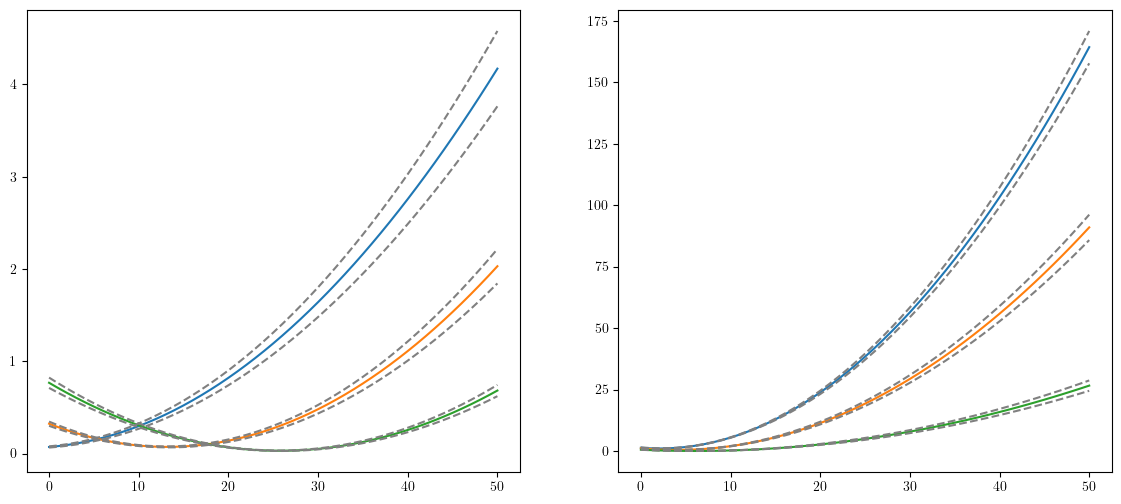

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(
    are_gmm.T,
)
axs[0].plot(are_gmm.T + est_se_gmm.T, "--", color="gray")
axs[0].plot(are_gmm.T - est_se_gmm.T, "--", color="gray")

axs[1].plot(
    are_gmm_scale.T,
)
axs[1].plot(are_gmm_scale.T + est_se_gmm_scale.T, "--", color="gray")
axs[1].plot(are_gmm_scale.T - est_se_gmm_scale.T, "--", color="gray")

plt.show()

In [18]:
(est_se_gmm / are_gmm).max(), (est_se_gmm_scale / are_gmm_scale).max()

(Array(0.10248584, dtype=float32), Array(0.11857404, dtype=float32))

In [19]:
df_est_mu = pd.DataFrame(
    {
        "sigma2": s2s,
        "normal": are_normal,
        "GMM_omega.1": are_gmm[0],
        "GMM_omega.5": are_gmm[1],
        "GMM_omega1": are_gmm[2],
        "GMM_scale_eps2.01": are_gmm_scale[0],
        "GMM_scale_eps2.1": are_gmm_scale[1],
        "GMM_scale_eps2.5": are_gmm_scale[2],
    }
)

df_est_mu.to_csv(here("data/figures/are_mu.csv"), index=False)

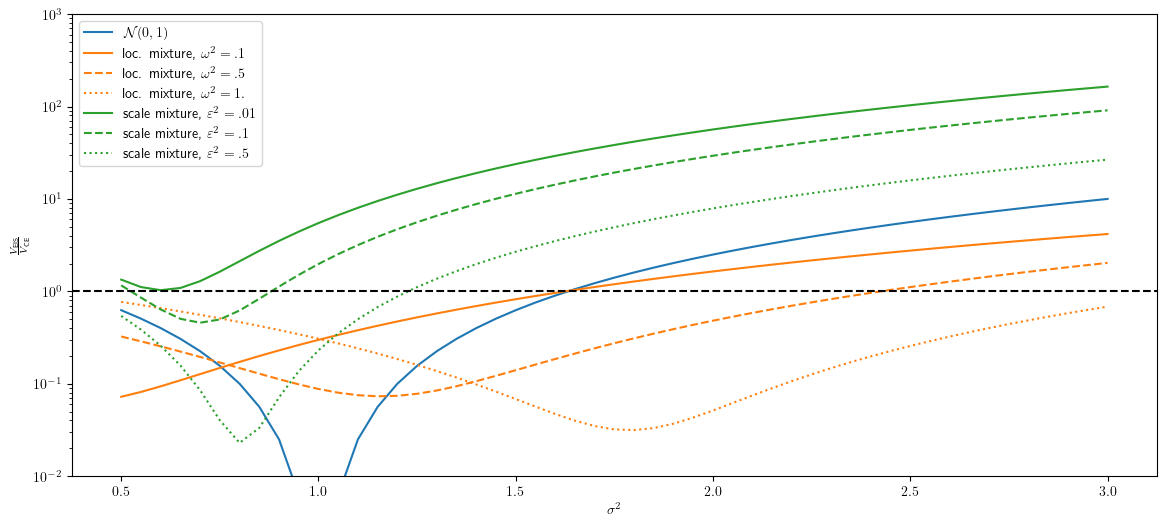

In [20]:
plt.plot(s2s, are_normal, label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(s2s, are_gmm[0], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(
    s2s,
    are_gmm[1],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    s2s,
    are_gmm[2],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(
    s2s,
    are_gmm_scale[0],
    label="scale mixture, $\\varepsilon^2 = .01$",
    color=colors[2],
)
plt.plot(
    s2s,
    are_gmm_scale[1],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    s2s,
    are_gmm_scale[2],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)

plt.axhline(1.0, color="black", linestyle="--")

plt.ylabel("$\\tfrac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\sigma^2$")

plt.yscale("log")
plt.ylim(10**-2, 10**3)

plt.legend()
plt.show()

## `data/figures/are_sigma2.csv`

In [21]:
V_eis_fun = lambdify((mu, tau), V_eis, "jax")
V_ce_fun = lambdify((mu, tau), V_ce, "jax")


def gmm_s2(mu, omega2, N, key, M):
    key, *keys = jrn.split(key, M + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
        components_distribution=Normal(jnp.array([-1.0, 1.0]), jnp.sqrt(omega2)),
    )
    mixture_estimators = partial(s2_ce_eis, P=P)

    return vmap(mixture_estimators, (None, 0, None))(N, keys, mu)


def gmm_scale_s2(mu, eps2, N, key, M):
    key, *keys = jrn.split(key, M + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
        components_distribution=Normal(
            jnp.array([0.0, 0.0]), jnp.array([1.0, 1 / jnp.sqrt(eps2)])
        ),
    )
    mixture_estimators = partial(s2_ce_eis, P=P)

    return vmap(mixture_estimators, (None, 0, None))(N, keys, mu)


def gmm_are_s2(mu, omega2, N, key, M):
    samples = gmm_s2(mu, omega2, N, key, M)
    var_ce, var_eis = samples.var(axis=0)
    est_se = bootstrap_se(samples, are, key)
    return var_eis / var_ce, est_se


def gmm_scale_are_s2(mu, eps2, N, key, M):
    samples = gmm_scale_s2(mu, eps2, N, key, M)
    var_ce, var_eis = samples.var(axis=0)
    est_se = bootstrap_se(samples, are, key)
    return var_eis / var_ce, est_se


veis = vmap(V_eis_fun, (0, None))(mus, 1.0)
vce = vmap(V_ce_fun, (0, None))(mus, 1.0)
are_normal = veis / vce

key, subkey = jrn.split(key)
are_gmm, se_are_gmm = vmap(
    vmap(gmm_are_s2, (0, None, None, None, None)), (None, 0, None, None, None)
)(mus, omega2s, N, subkey, M)
are_gmm_scale, se_are_gmm_scale = vmap(
    vmap(gmm_scale_are_s2, (0, None, None, None, None)), (None, 0, None, None, None)
)(mus, eps2s, N, subkey, M)

In [22]:
(se_are_gmm / are_gmm).max(), (se_are_gmm_scale / are_gmm_scale).max()

(Array(0.09679466, dtype=float32), Array(0.1093209, dtype=float32))

In [23]:
df_est_mu = pd.DataFrame(
    {
        "mu": mus,
        "normal": are_normal,
        "GMM_omega.1": are_gmm[0],
        "GMM_omega.5": are_gmm[1],
        "GMM_omega1": are_gmm[2],
        "GMM_scale_eps2.01": are_gmm_scale[0],
        "GMM_scale_eps2.1": are_gmm_scale[1],
        "GMM_scale_eps2.5": are_gmm_scale[2],
    }
)

df_est_mu.to_csv(here("data/figures/are_sigma2.csv"), index=False)

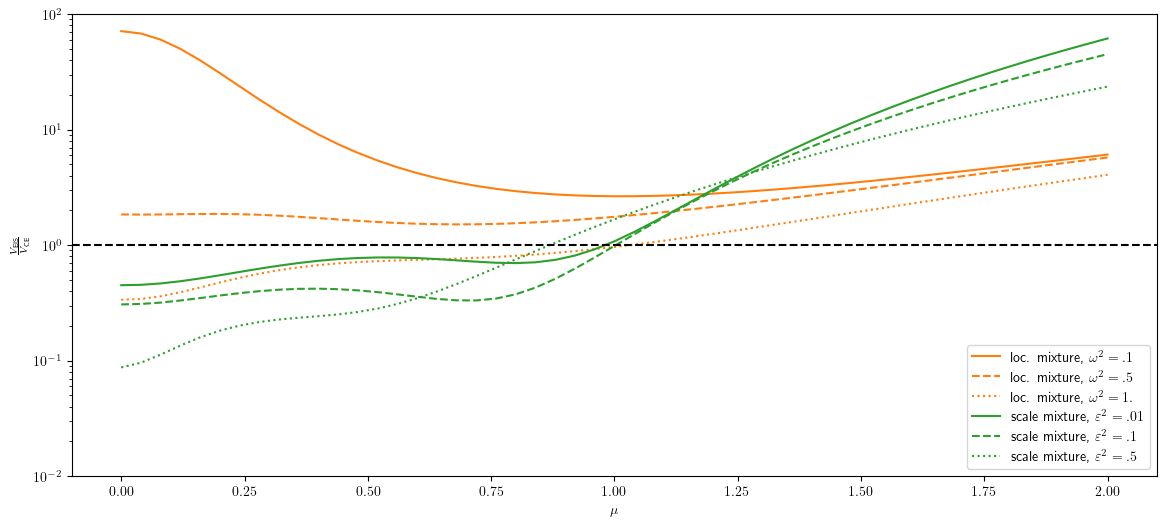

In [24]:
plt.plot(mus, are_gmm[0], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(
    mus,
    are_gmm[1],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    mus,
    are_gmm[2],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(
    mus,
    are_gmm_scale[0],
    label="scale mixture, $\\varepsilon^2 = .01$",
    color=colors[2],
)
plt.plot(
    mus,
    are_gmm_scale[1],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    mus,
    are_gmm_scale[2],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)
plt.axhline(1.0, color="black", linestyle="--")
plt.ylabel("$\\frac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\mu$")
plt.ylim(10**-2, 10**2)
plt.yscale("log")

plt.legend()
plt.show()

## `data/figures/{rho_cem_sigma2,cem_sigma2,rho_eis_sigma2,eis_sigma2}.csv`


In [25]:
vv_gmm_s2 = vmap(vmap(gmm_s2, (0, None, None, None, None)), (None, 0, None, None, None))
vv_gmm_scale_s2 = vmap(
    vmap(gmm_scale_s2, (0, None, None, None, None)), (None, 0, None, None, None)
)

psi_ces = jnp.array(
    [
        -1 / 2 / (tau2 + mus**2),  # normal
        *vv_gmm_s2(mus, omega2s, N, subkey, M).mean(axis=-2)[:, :, 0],  # loc. mixture
        *vv_gmm_scale_s2(mus, eps2s, N, subkey, M).mean(axis=-2)[
            :, :, 0
        ],  # scale mixture
    ]
)

# sigma2_normal_ces = -1/2/psi_ces
# rho_ce_normal = vmap(jnp_rho_normal, (None, None, 0,0))(0., 1., mus, jnp.sqrt(sigma2_normal_ces))


# rho_gmm = vmap(
#    vmap(jnp_rho_gmm, (None, None, 0,0)),
#    (None, 0, None, None)
# )(0., 1., mus, jnp.sqrt(sigma2_normal_ces))

sigma_ces = jnp.sqrt(-1 / 2 / psi_ces)
rho_ces_sigma2 = jnp.array(
    [
        vmap(jnp_rho_normal, (None, None, 0, 0))(0.0, tau2, mus, sigma_ces[0]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[0], mus, sigma_ces[1]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[1], mus, sigma_ces[2]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[2], mus, sigma_ces[3]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[0], mus, sigma_ces[4]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[1], mus, sigma_ces[5]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[2], mus, sigma_ces[6]),
    ]
)

In [26]:
psi_eiss_sigma2 = jnp.array(
    [
        -1 / 2 / (tau2 + 2 * mus**2),  # normal
        *vv_gmm_s2(mus, omega2s, N, subkey, M).mean(axis=-2)[:, :, 1],  # loc. mixture
        *vv_gmm_scale_s2(mus, eps2s, N, subkey, M).mean(axis=-2)[
            :, :, 1
        ],  # scale mixture
    ]
)

sigma_eiss = jnp.sqrt(-1 / 2 / psi_eiss_sigma2)
rho_eiss_sigma2 = jnp.array(
    [
        vmap(jnp_rho_normal, (None, None, 0, 0))(0.0, tau2, mus, sigma_eiss[0]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[0], mus, sigma_eiss[1]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[1], mus, sigma_eiss[2]),
        vmap(jnp_rho_glmm, (None, None, 0, 0))(1.0, omegas[2], mus, sigma_eiss[3]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[0], mus, sigma_eiss[4]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[1], mus, sigma_eiss[5]),
        vmap(jnp_rho_gsmm, (None, 0, 0))(epss[2], mus, sigma_eiss[6]),
    ]
)

In [27]:
df_rho_cem_sigma2 = pd.DataFrame(
    {
        "mu": mus,
        "normal": rho_ces_sigma2[0],
        "GMM_omega.1": rho_ces_sigma2[1],
        "GMM_omega.5": rho_ces_sigma2[2],
        "GMM_omega1": rho_ces_sigma2[3],
        "GMM_scale_eps.01": rho_ces_sigma2[4],
        "GMM_scale_eps.1": rho_ces_sigma2[5],
        "GMM_scale_eps.5": rho_ces_sigma2[6],
    }
)
df_rho_cem_sigma2.to_csv(here("data/figures/rho_cem_sigma2.csv"), index=False)

df_cem_sigma2_est = pd.DataFrame(
    {
        "mu": mus,
        "normal": sigma_ces[0] ** 2,
        "GMM_omega.1": sigma_ces[1] ** 2,
        "GMM_omega.5": sigma_ces[2] ** 2,
        "GMM_omega1": sigma_ces[3] ** 2,
        "GMM_scale_eps.01": sigma_ces[4] ** 2,
        "GMM_scale_eps.1": sigma_ces[5] ** 2,
        "GMM_scale_eps.5": sigma_ces[6] ** 2,
    }
)
df_cem_sigma2_est.to_csv(here("data/figures/cem_sigma2.csv"), index=False)


df_rho_eis_sigma2 = pd.DataFrame(
    {
        "mu": mus,
        "normal": rho_eiss_sigma2[0],
        "GMM_omega.1": rho_eiss_sigma2[1],
        "GMM_omega.5": rho_eiss_sigma2[2],
        "GMM_omega1": rho_eiss_sigma2[3],
        "GMM_scale_eps.01": rho_eiss_sigma2[4],
        "GMM_scale_eps.1": rho_eiss_sigma2[5],
        "GMM_scale_eps.5": rho_eiss_sigma2[6],
    }
)

df_rho_eis_sigma2.to_csv(here("data/figures/rho_eis_sigma2.csv"), index=False)

df_eis_sigma2_est = pd.DataFrame(
    {
        "mu": mus,
        "normal": sigma_eiss[0] ** 2,
        "GMM_omega.1": sigma_eiss[1] ** 2,
        "GMM_omega.5": sigma_eiss[2] ** 2,
        "GMM_omega1": sigma_eiss[3] ** 2,
        "GMM_scale_eps.01": sigma_eiss[4] ** 2,
        "GMM_scale_eps.1": sigma_eiss[5] ** 2,
        "GMM_scale_eps.5": sigma_eiss[6] ** 2,
    }
)
df_eis_sigma2_est.to_csv(here("data/figures/eis_sigma2.csv"), index=False)

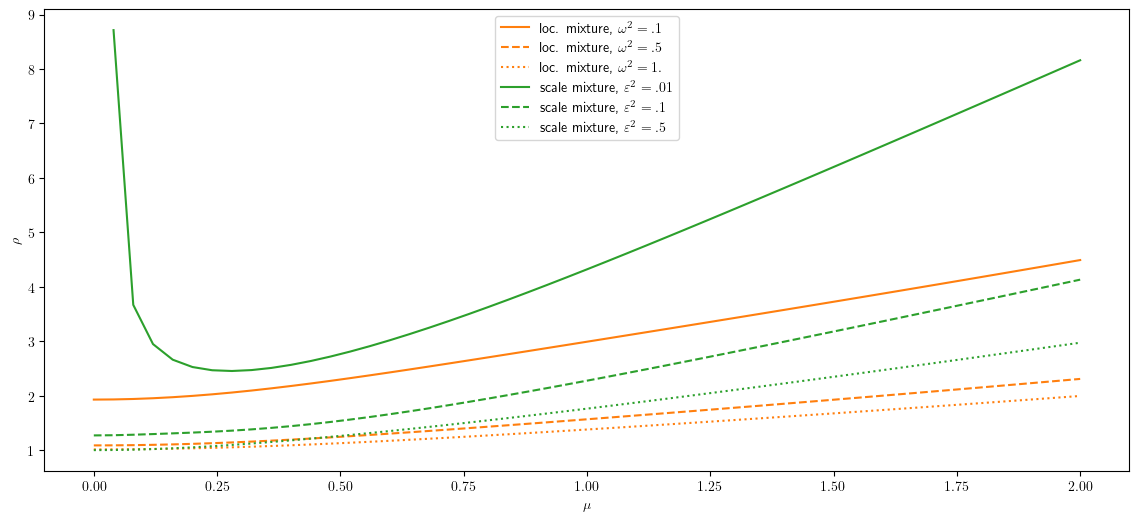

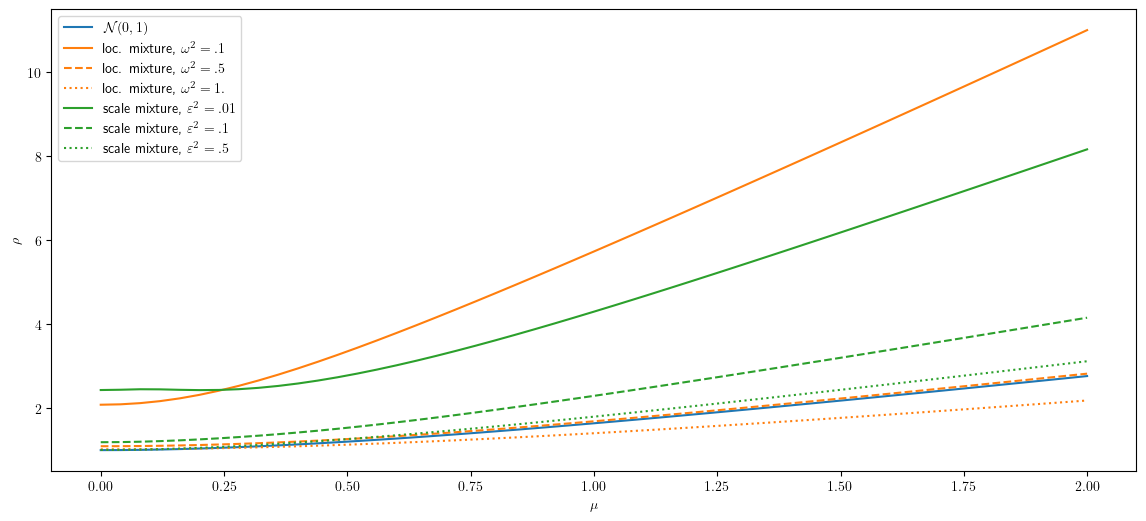

In [28]:
plt.plot(
    mus, rho_ces_sigma2[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1]
)
plt.plot(
    mus,
    rho_ces_sigma2[2],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    mus,
    rho_ces_sigma2[3],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(
    mus,
    rho_ces_sigma2[4],
    label="scale mixture, $\\varepsilon^2 = .01$",
    color=colors[2],
)
plt.plot(
    mus,
    rho_ces_sigma2[5],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    mus,
    rho_ces_sigma2[6],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)

plt.ylabel("$\\rho$")
plt.xlabel("$\\mu$")
# plt.ylim(10**-2, 10**2)
# plt.yscale("log")

plt.legend()
# tikzplotlib.save("../tikz/are_mu.tex")
plt.show()
plt.plot(mus, rho_eiss_sigma2[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(
    mus, rho_eiss_sigma2[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1]
)
plt.plot(
    mus,
    rho_eiss_sigma2[2],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    mus,
    rho_eiss_sigma2[3],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(
    mus,
    rho_eiss_sigma2[4],
    label="scale mixture, $\\varepsilon^2 = .01$",
    color=colors[2],
)
plt.plot(
    mus,
    rho_eiss_sigma2[5],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    mus,
    rho_eiss_sigma2[6],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)

plt.ylabel("$\\rho$")
plt.xlabel("$\\mu$")
# plt.ylim(10**-2, 10**2)
# plt.yscale("log")

plt.legend()
# tikzplotlib.save("../tikz/are_mu.tex")
plt.show()

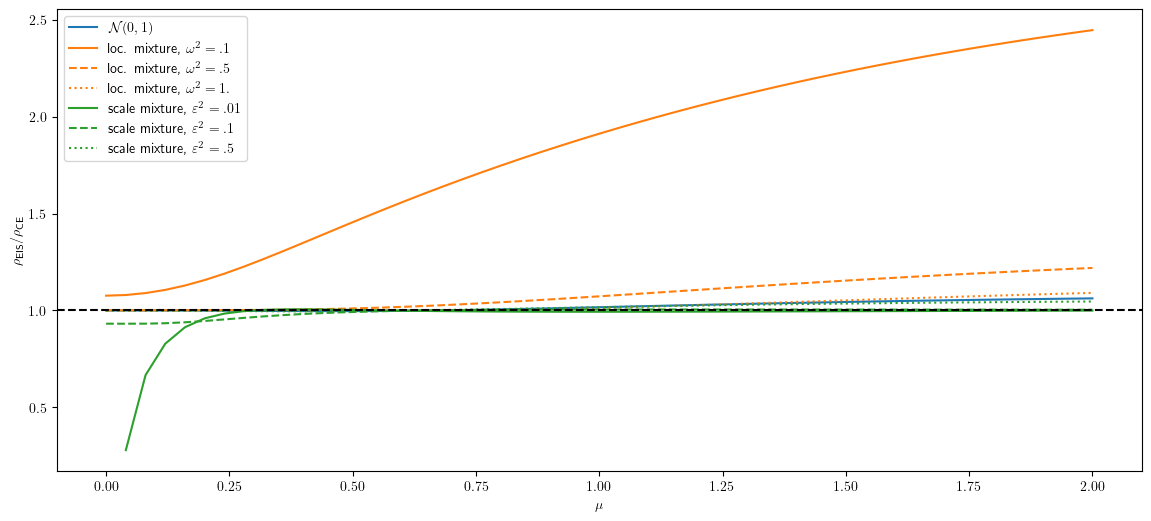

In [29]:
relative_rho = rho_eiss_sigma2 / rho_ces_sigma2
plt.plot(mus, relative_rho[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(mus, relative_rho[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(
    mus,
    relative_rho[2],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    mus,
    relative_rho[3],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(
    mus, relative_rho[4], label="scale mixture, $\\varepsilon^2 = .01$", color=colors[2]
)
plt.plot(
    mus,
    relative_rho[5],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    mus,
    relative_rho[6],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)

plt.ylabel("$\\rho_{\\text{EIS}} / \\rho_{\\text{CE}}$")
plt.xlabel("$\\mu$")
plt.axhline(1.0, color="black", linestyle="--")
# plt.ylim(10**-2, 10**2)
# plt.yscale("log")

plt.legend()
# tikzplotlib.save("../tikz/are_mu.tex")
plt.show()

## `data/figures/rho_mu.csv`: $\rho$ for fixed $\sigma^2$

in this case $\mu = 0$ for both CEM and EIS

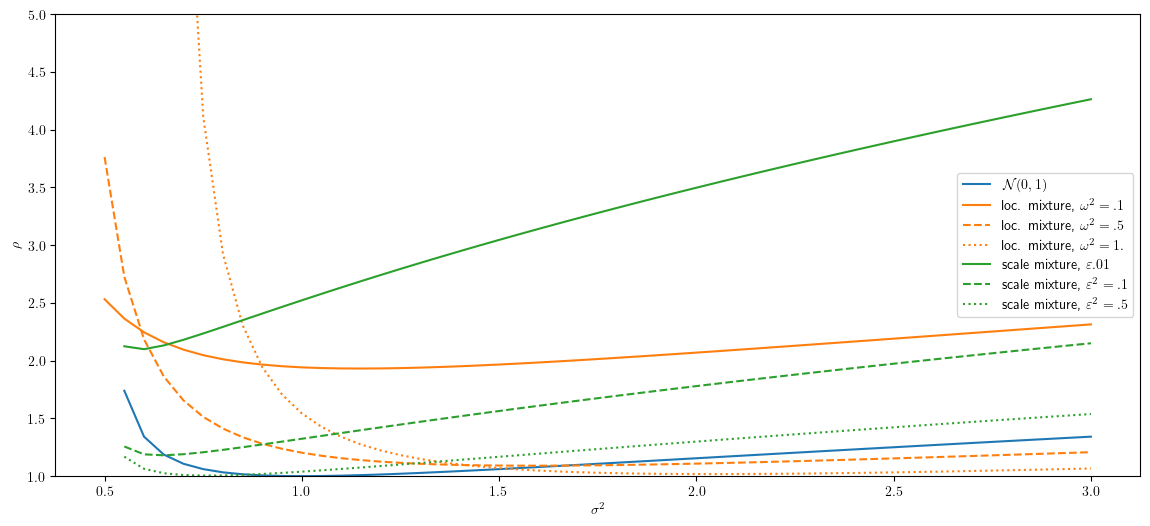

In [30]:
# sigma2_normal_ces = -1/2/psi_ces
# rho_ce_normal = vmap(jnp_rho_normal, (None, None, 0,0))(0., 1., mus, jnp.sqrt(sigma2_normal_ces))


# rho_gmm = vmap(
#    vmap(jnp_rho_gmm, (None, None, 0,0)),
#    (None, 0, None, None)
# )(0., 1., mus, jnp.sqrt(sigma2_normal_ces))

rho_mu = jnp.array(
    [
        vmap(jnp_rho_normal, (None, None, None, 0))(0.0, tau2, 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_glmm, (None, None, None, 0))(1.0, omegas[0], 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_glmm, (None, None, None, 0))(1.0, omegas[1], 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_glmm, (None, None, None, 0))(1.0, omegas[2], 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_gsmm, (None, None, 0))(epss[0], 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_gsmm, (None, None, 0))(epss[1], 0.0, jnp.sqrt(s2s)),
        vmap(jnp_rho_gsmm, (None, None, 0))(epss[2], 0.0, jnp.sqrt(s2s)),
    ]
)

df_rho_mu = pd.DataFrame(
    {
        "sigma2": s2s,
        "normal": rho_mu[0],
        "GMM_omega.1": rho_mu[1],
        "GMM_omega.5": rho_mu[2],
        "GMM_omega1": rho_mu[3],
        "GMM_scale_eps.01": rho_mu[4],
        "GMM_scale_eps.1": rho_mu[5],
        "GMM_scale_eps.5": rho_mu[6],
    }
)
df_rho_mu.to_csv(here("data/figures/rho_mu.csv"), index=False)

plt.plot(s2s, rho_mu[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(s2s, rho_mu[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(
    s2s,
    rho_mu[2],
    label="loc. mixture, $\\omega^2 = .5$",
    color=colors[1],
    linestyle="--",
)
plt.plot(
    s2s,
    rho_mu[3],
    label="loc. mixture, $\\omega^2 = 1.$",
    color=colors[1],
    linestyle=":",
)
plt.plot(s2s, rho_mu[4], label="scale mixture, $\\varepsilon.01$", color=colors[2])
plt.plot(
    s2s,
    rho_mu[5],
    label="scale mixture, $\\varepsilon^2 = .1$",
    color=colors[2],
    linestyle="--",
)
plt.plot(
    s2s,
    rho_mu[6],
    label="scale mixture, $\\varepsilon^2 = .5$",
    color=colors[2],
    linestyle=":",
)

plt.ylabel("$\\rho$")
plt.xlabel("$\\sigma^2$")
plt.ylim(1, 5)

plt.legend()
plt.show()

## `data/figures/gssm_eps.csv`

In [40]:
from functools import partial

vareps = jnp.logspace(-2, 0, 51)

are_eps, are_eps_se = vmap(partial(gmm_scale_are_s2, mu=0.0, N=N, key=subkey, M=M))(
    eps2=vareps**2
)

s2_est = (
    -1 / 2 / vmap(partial(gmm_scale_s2, mu=0.0, N=N, key=subkey, M=M))(eps2=vareps**2)
)

In [42]:
s2_cem, s2_eis = jnp.nanmean(s2_est, axis=1).T
s2_cem = 1 / 2 * (1 + 1 / vareps**2)
rho_eps_cem = vmap(jnp_rho_gsmm, (0, None, 0))(vareps, 0.0, jnp.sqrt(s2_cem))
rho_eps_eis = vmap(jnp_rho_gsmm, (0, None, 0))(vareps, 0.0, jnp.sqrt(s2_eis))

In [46]:
pd.DataFrame(
    {
        "epsilon": vareps,
        "sigma2_cem": s2_cem,
        "sigma2_eis": s2_eis,
        "rho_cem": rho_eps_cem,
        "rho_eis": rho_eps_eis,
        "are": are_eps,
    }
).to_csv(here("data/figures/gsmm_eps.csv"), index=False)

In [47]:
vareps[jnp.argmax(1 / 2 / vareps**2 < s2_eis)]

Array(0.08317637, dtype=float32)

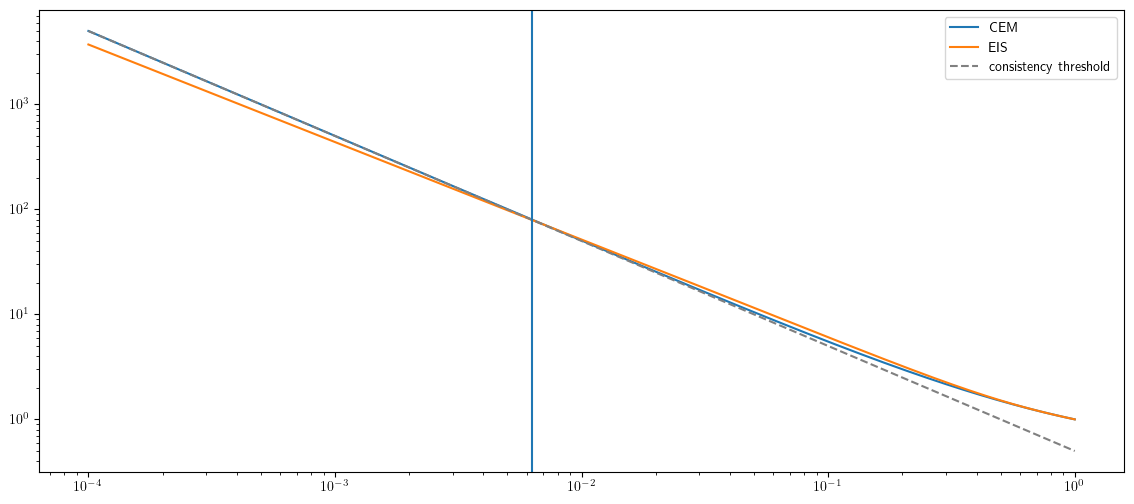

In [ ]:
plt.plot(vareps**2, s2_cem, label="CEM")
plt.plot(vareps**2, s2_eis, label="EIS")
plt.plot(
    vareps**2,
    1 / 2 / vareps**2,
    color="grey",
    linestyle="--",
    label="consistency threshold",
)
plt.axvline(vareps[jnp.argmax(1 / 2 / vareps**2 < s2_eis)] ** 2)
plt.legend()
plt.yscale("log")
plt.xscale("log")

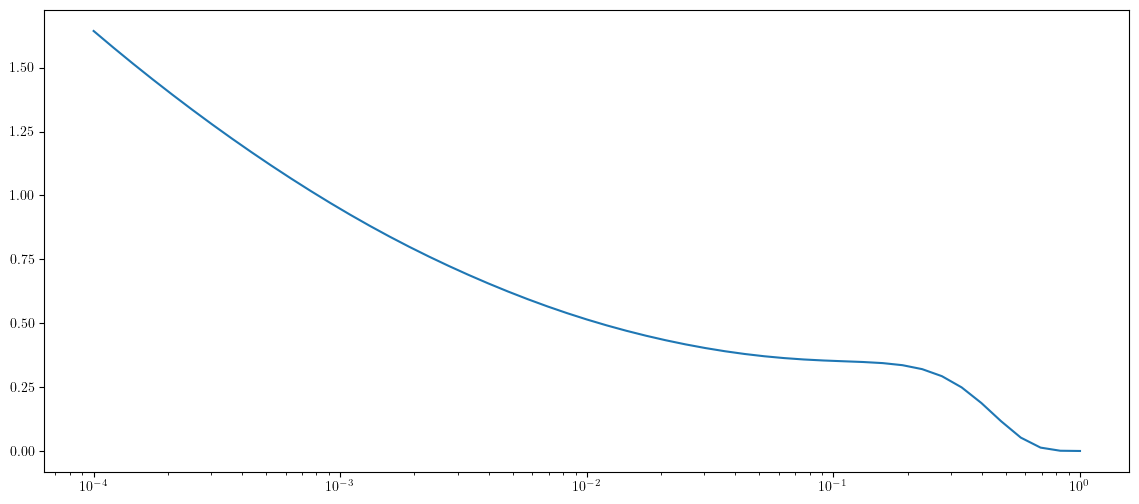

In [48]:
plt.plot(vareps**2, are_eps)
plt.xscale("log")

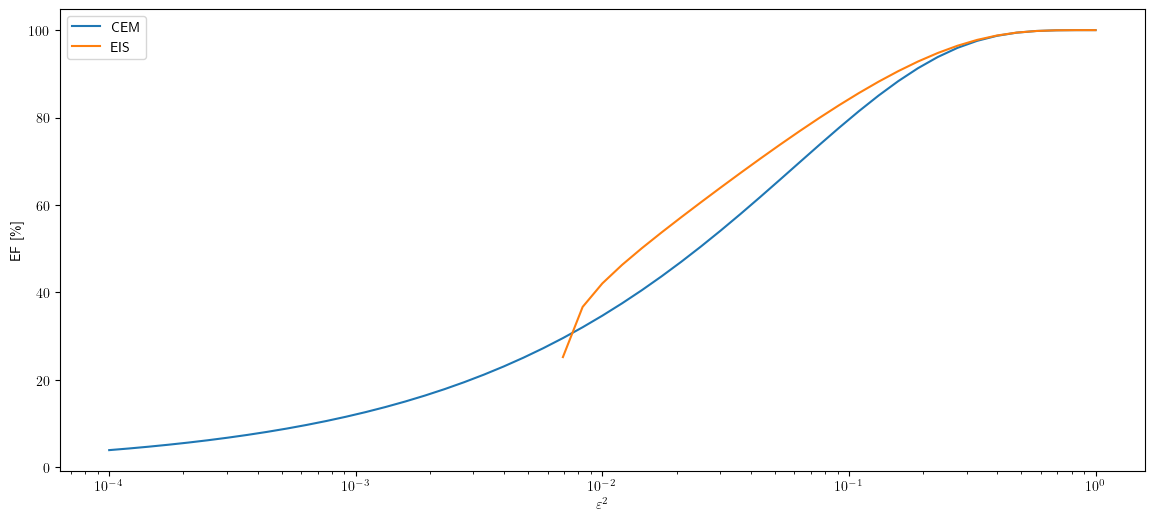

In [49]:
plt.plot(vareps**2, 1 / rho_eps_cem * 100, label="CEM")
plt.plot(vareps**2, 1 / rho_eps_eis * 100, label="EIS")
plt.xscale("log")
plt.legend()
plt.ylabel("EF [\\%]")
plt.xlabel("$\\varepsilon^2$")
plt.show()

# Draft code

In [ ]:
assert False
key = jrn.PRNGKey(10)
key, *keys = jrn.split(key, 101)

keys = jnp.array(keys)

Ns = jnp.logspace(1, 5, 9).astype(int)

omega2 = 1.0
s2 = 10000.0

normal_estimators = partial(mu_ce_eis, P=Normal(0.0, jnp.sqrt(omega2)))

vars = jnp.array(
    [(vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0) for N in Ns]
)

coef_ce = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:, 0]), 1)
coef_eis = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:, 1]), 1)

plt.scatter(Ns, vars[:, 0])
plt.scatter(Ns, vars[:, 1])

plt.plot(
    Ns, jnp.exp(coef_ce[1]) * Ns ** coef_ce[0], label=f"CE: {coef_ce[0]:.2f}", alpha=0.5
)
plt.plot(
    Ns,
    jnp.exp(coef_eis[1]) * Ns ** coef_eis[0],
    label=f"EIS: {coef_eis[0]:.2f}",
    alpha=0.5,
)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

AssertionError: 

<IPython.core.display.Latex object>

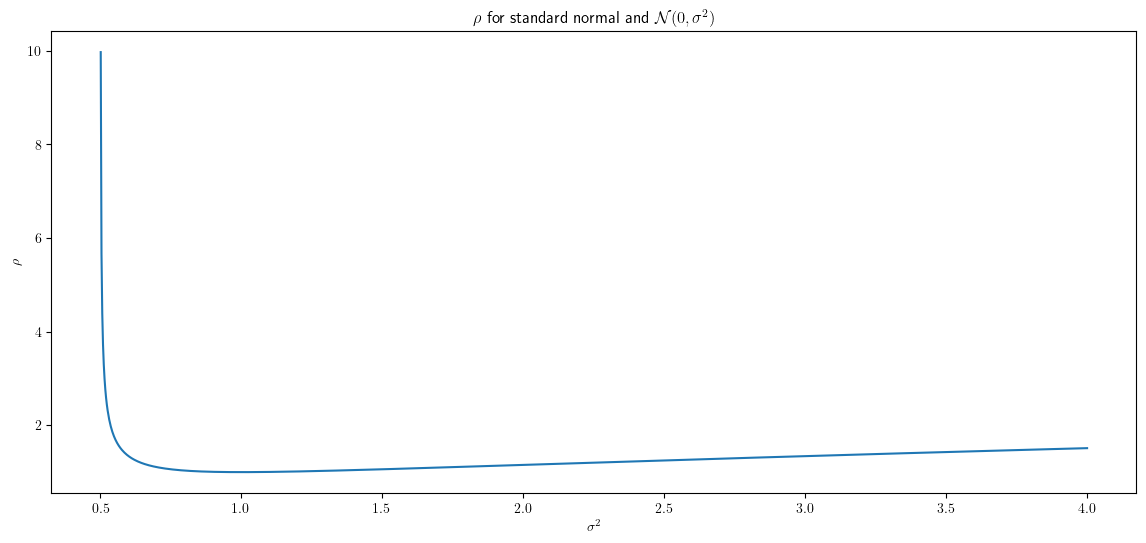

In [ ]:
# second moment of weights under G, for P = N(nu, tau**2), G = N(mu, sigma**2)
# int p^2/g
show(
    "\\rho_{\\mathcal N(\\nu, \\tau^2), \\mathcal N(\\mu, \\sigma^2)}",
    rho_normal().simplify(),
)

sigs = jnp.linspace(0.1, 2, 1001)
epss = vmap(jnp_rho_normal, (None, None, None, 0))(0.0, 1.0, 0.0, sigs)
plt.title("$\\rho$ for standard normal and $\\mathcal N (0, \\sigma^2)$")
plt.plot(sigs**2, epss)
plt.ylabel("$\\rho$")
plt.xlabel("$\\sigma^2$")
plt.show()

$\providecommand{\G}{\mathbf G}$
Second moment of weights for $\P = \mathcal N (\nu, \tau^2)$, $\G = \mathcal N (\mu, \sigma^2)$

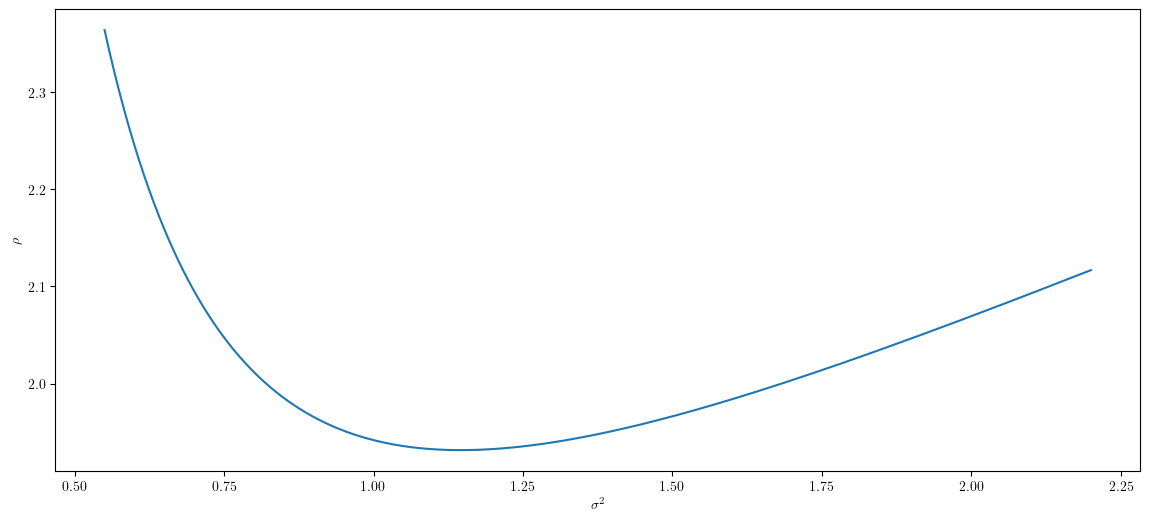

In [ ]:
omega2 = 0.1
P = MixtureSameFamily(
    mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
    components_distribution=Normal(jnp.array([-1.0, 1.0]), jnp.sqrt(omega2)),
)
key, *keys = jrn.split(key, 101)
keys = jnp.array(keys)

-1 / 2 / vmap(partial(s2_ce_eis, P=P), (None, 0, None))(int(1e4), keys, 0.0).mean(
    axis=0
)

tau2 = 0.1
sig2s = jnp.linspace(1 / 2 + tau2 / 2, 2 + 2 * tau2, 1001)
epss = vmap(jnp_rho_glmm, (None, None, None, 0))(
    -1.0, jnp.sqrt(tau2), 0.0, jnp.sqrt(sig2s)
)
plt.plot(sig2s, epss)
plt.xlabel("$\\sigma^2$")
plt.ylabel("$\\rho$")
plt.show()

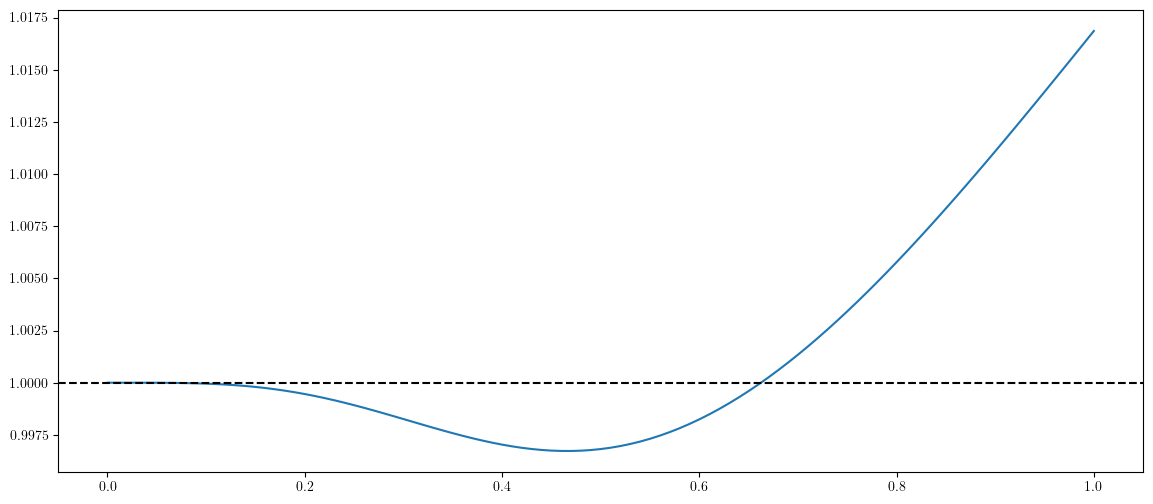

In [ ]:
sigma_ce_fun = lambdify((mu, tau), sqrt(-1 / 2 / psie_ce_normal_variance), "jax")
sigma_eis_fun = lambdify((mu, tau), sqrt(-1 / 2 / psi_eis_normal_variance), "jax")


mus = jnp.linspace(0, 1, 101)
sigma_ces = vmap(sigma_ce_fun, (0, None))(mus, 1.0)
sigma_eiss = vmap(sigma_eis_fun, (0, None))(mus, 1.0)
rho_ce = vmap(jnp_rho_normal, (None, None, 0, 0))(0.0, 1.0, mus, sigma_ces)
rho_eis = vmap(jnp_rho_normal, (None, None, 0, 0))(0.0, 1.0, mus, sigma_eiss)

plt.plot(mus, rho_eis / rho_ce)
plt.axhline(1.0, color="black", linestyle="--")
plt.show()

## $\mu$ and $\sigma$ joint

In [ ]:
def ce_joint(samples, weights):
    mu = jnp.sum(samples * weights)
    s2 = jnp.cov(samples, aweights=weights)
    return jnp.array([mu, s2])


def eis_joint(samples, weights, logp):
    (N,) = weights.shape
    X = jnp.array([jnp.ones(N), samples, -1 / 2 * samples**2]).reshape((3, N)).T

    wX = jnp.einsum("i,ij->ij", jnp.sqrt(weights), X)
    y = jnp.sqrt(weights) * logp
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    s2 = 1 / beta[2]
    mu = beta[1] * s2

    return jnp.array([mu, s2])


def optim_params(P, N, key):
    key, subkey = jrn.split(key)
    samples = P.sample(seed=subkey, sample_shape=(N,))
    weights = jnp.ones(N) / N
    return ce_joint(samples, weights), eis_joint(samples, weights, P.log_prob(samples))


Ps = [
    Normal(0.0, 1.0),
    *[
        MixtureSameFamily(
            mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
            components_distribution=Normal(jnp.array([-1.0, 1.0]), jnp.sqrt(o2)),
        )
        for o2 in omega2s
    ],
    *[
        MixtureSameFamily(
            mixture_distribution=Categorical(probs=jnp.array([0.5, 0.5])),
            components_distribution=Normal(
                jnp.array([0.0, 0.0]), jnp.array([1.0, 1 / jnp.sqrt(e2)])
            ),
        )
        for e2 in eps2s
    ],
]

key, subkey = jrn.split(key)
mu_s2 = jnp.array([optim_params(P, int(1e4), subkey) for P in Ps])
mu_s2[:, :, 1]

mu_s2

Array([[[-7.2664702e-03,  9.8180073e-01],
        [ 1.7051578e-07,  9.9994385e-01]],

       [[ 2.3707466e-03,  1.1001630e+00],
        [ 1.3844248e-02,  1.8770221e+00]],

       [[ 2.8290155e-03,  1.5029979e+00],
        [ 8.9647705e-03,  1.6795250e+00]],

       [[ 3.1724076e-03,  2.0071158e+00],
        [ 4.8467512e-03,  2.0484262e+00]],

       [[ 1.3028036e-03,  5.1495647e-01],
        [-6.3571180e-03,  5.4142958e-01]],

       [[ 1.2714751e-03,  5.5995786e-01],
        [-4.8955558e-03,  6.2857640e-01]],

       [[ 1.2148431e-03,  7.5995421e-01],
        [-2.3151147e-04,  7.7156228e-01]]], dtype=float32)

In [ ]:
omega2s

Array([0.1, 0.5, 1. ], dtype=float32)